# 1. Introduction
## 1.1. Project Goal

The primary goal of this project is to develop and evaluate predictive models that can accurately forecast the next day's gold price. By comparing the performance of different models, we aim to identify the most effective approach for predicting gold prices. The insights gained from this project can help in understanding the strengths and limitations of various modeling techniques in the context of financial time-series data.

## 1.2. Objectives

1. **Data Preprocessing**: To clean and prepare the dataset for analysis and modeling.
2. **Exploratory Data Analysis (EDA)**: To understand the underlying patterns and relationships within the data.
3. **Feature Engineering**: To select and transform features that are most relevant for predicting gold prices.
4. **Model Selection and Training**: To train and evaluate various models and identify the best-performing model.
5. **Model Evaluation**: To compare the performance of different models using metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² score.
6. **Next Day Prediction**: To deploy the best-performing models for predicting the next day's gold price.

# 2. Data Collection

## 2.1. Source of Data
The dataset is sourced from Sahil Wagh on Kaggle - Gold Stock Prices, which can be found at the following URL: https://www.kaggle.com/datasets/sahilwagh/gold-stock-prices

The most current gold prices can be downloaded from: https://www.investing.com/commodities/gold-historical-data

## 2.2. Composition of the Dataset

The dataset used in this project consists of historical gold prices and related features. The data includes daily records of:
- **Index**: The surrogate index of the record.
- **Date**: The date of the record.
- **Open**: The opening price of gold on that day.
- **High**: The highest price of gold on that day.
- **Low**: The lowest price of gold on that day.
- **Close/Last**: The closing price of gold on that day.
- **Volume**: The trading volume of gold on that day.

# 3. Data Preprocessing

In [50]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from prophet import Prophet

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

import matplotlib.pyplot as plt
import seaborn as sns

# Model saving and loading
import joblib

## 3.1. Loading the Dataset

In [8]:
df = pd.read_csv('goldstock.csv')

print(df.head(5))

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True) # Convert Date column into a common format
df = df.sort_values('Date')
df.set_index('Date', inplace=True) # Set Date as the index
df = df.drop('Index', axis=1)

print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')

   Index        Date  Close/Last  Volume    Open    High     Low
0   2528  07/07/2014      1317.0   79110  1321.4  1321.7  1312.1
1   2527  08/07/2014      1316.5  126706  1320.8  1325.7  1314.3
2   2526  09/07/2014      1324.3  155101  1320.4  1333.4  1318.7
3   2525  10/07/2014      1339.2  167391  1325.0  1346.8  1325.0
4   2524  11/07/2014      1337.4   88470  1336.5  1340.4  1334.6
The dataset contains 2511 rows and 5 columns.


## 3.2. Handling Missing Values

In [9]:
print(df.isnull().sum())

Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64


## 3.3. Splitting the Dataset

In [10]:
# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:] # train = first 8 years, test = last 2 years

# 4. Exploratory Data Analysis (EDA)

## 4.1. Histograms of Features

In [ ]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

![barcharts](https://i.imgur.com/BSKkFRQ.png)

The histograms reveal that the **Close/Last, High, Low, and Open** prices have similar distributions, indicating they are closely related and move together. 

In contrast, the **Volume** is right-skewed with outliers, suggesting many days with low trading volumes and a few with very high volumes.

## 4.2. Close Prices over Time

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close/Last'])
plt.title('Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.show()

![linechart](https://i.imgur.com/DPiqHB7.png)

Three distinct phases were observed:
- **2014-2016**: Prices hovered around 2000, reflecting market correction.
- **2016-2020**: Steady increase, reaching 2185.5 by end of 2020.
- **2020-2024**: Marked volatility, peaking at 2407.8 in early 2024.
This trend underscores gold's role as a safe-haven asset, particularly during economic uncertainties, geopolitical tensions and the diminishing status of the US dollar.

## 4.3. Heatmap of the Correlation Matrix

In [ ]:
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

print(corr_matrix)

![correlationmatrix](https://i.imgur.com/5o6keyb.png)

**Close/Last, Open, High, and Low** are all perfectly, positvely correlated with each other, indicating that these price-related features move very closely together. They might provide redundant information about gold prices if used together for modeling.

**Volume** shows very weak correlation with all price-related features, suggesting that trading volume does not have a strong linear relationship with the price movements of gold.

## 4.4. Pair Plots for Visualizing Feature Relationships

In [ ]:
sns.pairplot(df)
plt.show()

![pairlots](https://i.imgur.com/4JFT0rQ.png)

**Close/Last, Open, High, Low**

The pair plots show straight positive lines between Close/Last, Open, High, and Low, indicating a near-perfect linear relationship. This aligns with the correlation matrix, where these features have values close to 1, reflecting their strong interdependence.

**Volume**

The pair plots for Volume show random scattered points compared to the price features, indicating no clear linear relationship. This is consistent with the correlation matrix, where Volume has very low correlation values with the price features, suggesting its independence from price movements.

## 4.5. Box Plot to Detect Outliers

In [ ]:
plt.figure(figsize=(15, 10))
df.boxplot(column=[col for col in df.columns if col != 'Volume'])
plt.title('Box Plots of All Features Except Volume')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
df.boxplot(column=['Volume'])
plt.title('Box Plot of Volume Feature')
plt.show()

![botplot_rest](https://i.imgur.com/jCflbiK.png)
![boxplot_volume](https://i.imgur.com/RxiSykg.png)

**Volume Outliers**

The Volume feature has many outliers, indicating periods of unusually high trading activity, likely driven by significant market events or news.

**Price Features (Close/Last, Open, High, Low)**

The Close/Last, Open, High, and Low features show no outliers, suggesting stable and consistent gold prices uptrend without extreme fluctuations.

## 4.6. Moving Averages

In [ ]:
df['MA_30'] = df['Close/Last'].rolling(window=30).mean()
df['MA_90'] = df['Close/Last'].rolling(window=90).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['Close/Last'], label='Close/Last')
plt.plot(df['MA_30'], label='30-Day Moving Average')
plt.plot(df['MA_90'], label='90-Day Moving Average')
plt.title('Gold Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

![movingavg](https://i.imgur.com/aEUBO0A.png)

# 5. Feature Engineering

The following feature engineering is justified as follows: 

- The high correlation between the price features **(Close/Last, Open, High, Low)** indicates redundancy, so only the **'Open'** price is selected as it strongly predicts **'Close/Last'**. 
- **Volume** is not included because it shows minimal correlation with the closing price, indicating it does not add predictive value. 
- **Normalization** using MinMaxScaler is appropriate since the absence of outliers in the price features ensures that scaling will be effective without being skewed by extreme values.

It is worth noting that different sets of features were also tested on the LSTM model, including **lag features** and **moving averages**. However, the model tended to overfit with the added features.

In [11]:
# Feature selection
features = ['Open']
X_train = train[features]
y_train = train['Close/Last']
X_test = test[features]
y_test = test['Close/Last']

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# 6. Model Selection

## 6.1. Prophet Model

**Prophet** is ideal for time-series forecasting with strong seasonal effects and trends, it will be seen if this is a good fit for the nature of gold prices.

In [12]:
def prophet_model(train, test):
    train_df = train.reset_index().rename(columns={'Date': 'ds', 'Close/Last': 'y'})
    test_df = test.reset_index().rename(columns={'Date': 'ds', 'Close/Last': 'y'})
    model = Prophet()
    model.fit(train_df[['ds', 'y']])
    future = test_df[['ds']]
    forecast = model.predict(future)
    y_pred = forecast['yhat'].values
    evaluate_model('Prophet', test_df['y'].values, y_pred)

## 6.2. Linear Regression Model

**Linear Regression** is appropriate due to the strong linear relationship between 'Open' and 'Close/Last' prices.

In [40]:
def linear_regression_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    # joblib.dump(model, 'linear_regression_model.pkl')  # Save the trained model to a file
    y_pred = model.predict(X_test)
    evaluate_model('Linear Regression', y_test, y_pred)

## 6.3. Random Forest Model

**Random Forest** can capture non-linear patterns and interactions, providing robust predictions. It also prevents overfitting through ensemble learning.

In [14]:

def random_forest_model(X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model('Random Forest', y_test, y_pred)

## 6.4. XGBoost Model

**XGBoost** also excels in handling complex, non-linear relationships and interactions. Its regularization techniques prevent overfitting.

In [15]:
def xgboost_model(X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model('XGBoost', y_test, y_pred)

## 6.5. LSTM Model

**LSTM** networks are designed for sequential data, capturing long-term dependencies and trends. Their ability to model temporal dependencies makes them well-suited for forecasting gold prices based on historical patterns.

In [16]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)
    
def lstm_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, shuffle=False)

    y_pred_scaled = model.predict(X_test_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test_seq)
    evaluate_model('LSTM', y_test_actual, y_pred)


def lstm_pretrained_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, path):
    
    # Load the pre-trained model
    model = load_model(path)

    y_pred_scaled = model.predict(X_test_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test_seq)
    evaluate_model('LSTM', y_test_actual, y_pred)

# 7. Model Training

In [17]:
results = {}
predictions = {}
# Function to evaluate and store results
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    predictions[name] = y_pred
    print(f'{name} - MSE: {mse}, MAE: {mae}, R2: {r2}')

In [18]:
prophet_model(train, test)

12:56:24 - cmdstanpy - INFO - Chain [1] start processing
12:56:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MSE: 45495.06279289315, MAE: 162.31036549031757, R2: -0.23418277528830989


In [41]:
linear_regression_model(X_train_scaled, y_train, X_test_scaled, y_test)

Linear Regression - MSE: 276.761315010601, MAE: 12.398099302712678, R2: 0.9924920633826319


In [20]:
random_forest_model(X_train, y_train, X_test, y_test)

Random Forest - MSE: 15695.080121419429, MAE: 64.0409768389661, R2: 0.5742263807656129


In [21]:
xgboost_model(X_train, y_train, X_test, y_test)

XGBoost - MSE: 16405.238002555252, MAE: 63.68193660303803, R2: 0.554961331531084


In [22]:
path = "gold_price_prediction_model.h5"
lstm_pretrained_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, path)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM - MSE: 1037.0268547685444, MAE: 25.49753363495183, R2: 0.9717384560132398


In [23]:
print(results)

{'Prophet': {'MSE': 45495.06279289315, 'MAE': 162.31036549031757, 'R2': -0.23418277528830989}, 'Linear Regression': {'MSE': 276.761315010601, 'MAE': 12.398099302712678, 'R2': 0.9924920633826319}, 'Random Forest': {'MSE': 15695.080121419429, 'MAE': 64.0409768389661, 'R2': 0.5742263807656129}, 'XGBoost': {'MSE': 16405.238002555252, 'MAE': 63.68193660303803, 'R2': 0.554961331531084}, 'LSTM': {'MSE': 1037.0268547685444, 'MAE': 25.49753363495183, 'R2': 0.9717384560132398}}


# 8. Model Evaluation

## 8.1. Performance Visualizations

### 8.1.1. Bar Charts of Model Performance (MSE, MAE)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the results
metrics = ['MSE', 'MAE']
colors = ['b', 'g']

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.4
index = np.arange(len(results))

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in results]
    ax.bar(index + i * bar_width, values, bar_width, label=metric, color=colors[i])

ax.set_xlabel('Model')
ax.set_ylabel('Log Scale')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(results.keys())
ax.set_yscale('log')  # Set y-axis to log scale
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(metrics))

plt.tight_layout()
plt.show()

![MSE_MAE](https://i.imgur.com/s1YHnXR.png)

### 8.1.2. Horizontal Bars of R^2 metric

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), [results[model]['R2'] for model in results])
plt.title('R^2 Comparison')
plt.xlabel('R^2')
plt.ylabel('Model')
plt.show()

![Rsquare](https://i.imgur.com/sK5whJd.png)

### 8.1.3. Interactive Graph of Predictions vs Actual Test values

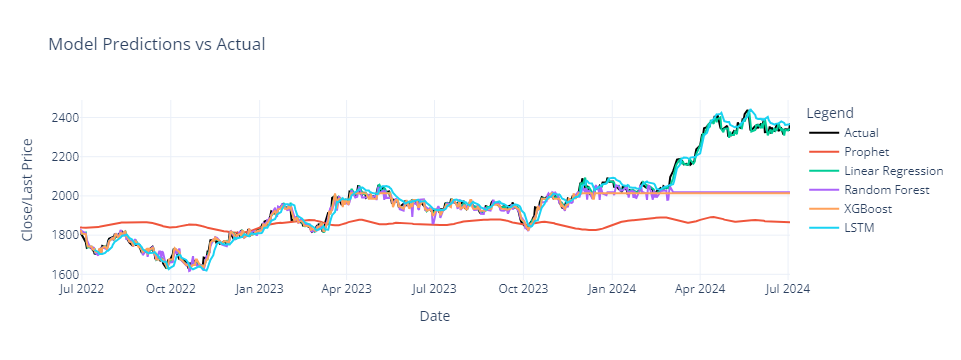

In [59]:
import plotly.graph_objects as go

def plot_predictions(test, predictions):
    fig = go.Figure()

    # Add actual values
    fig.add_trace(go.Scatter(x=test.index, y=test.values, mode='lines', name='Actual', line=dict(color='black')))

    # Add predictions for each model
    for model_name, y_pred in predictions.items():
        if len(y_pred) < len(test):
            x_values = test.index[-len(y_pred):]
        else:
            x_values = test.index
        fig.add_trace(go.Scatter(x=x_values, y=y_pred.flatten(), mode='lines', name=model_name))

    # Update layout
    fig.update_layout(
        title='Model Predictions vs Actual',
        xaxis_title='Date',
        yaxis_title='Close/Last Price',
        legend_title='Legend',
        template='plotly_white'
    )

    fig.show()

plot_predictions(test['Close/Last'], predictions)

![predictions](https://i.imgur.com/j3zXCPW.png)

## 8.2. Table of Evaluation Results

| Model             | MSE          | MAE          | R²          |
|-------------------|--------------|--------------|-------------|
| Prophet           | 45495.06     | 162.31       | -0.23       |
| Linear Regression | 276.76       | 12.40        | 0.99        |
| Random Forest     | 15695.08     | 64.04        | 0.57        |
| XGBoost           | 16405.24     | 63.68        | 0.55        |
| LSTM              | 1037.03      | 25.50        | 0.97        |

## 8.3. Analysis of Results

- **Prophet Model**: shows the highest MSE and MAE, indicating poor predictive performance. The negative R² value suggests that the model performs worse than a simple mean-based model. This poor performance can be attributed to Prophet's design, which is better suited for capturing seasonality and trends in time series data, rather than the specific linear relationships present in gold prices.

- **Linear Regression Model**: performs exceptionally well, with the lowest MSE and MAE among all models. The R² value of 0.99 indicates that the model explains 99% of the variance in the target variable. This excellent performance is due to the strong linear relationship between the 'Open' and 'Close/Last' prices.

- **Random Forest Model**: shows moderate performance with a relatively high MSE and MAE. The R² value of 0.57 indicates that the model explains 57% of the variance. While Random Forest can capture non-linear patterns, its performance is hindered by the high correlation and linear nature of the price features, which do not benefit significantly from the model's complexity.

- **XGBoost Model**: performs similarly to Random Forest, with slightly higher MSE and MAE. Like Random Forest, XGBoost's performance is limited by the linear relationships in the data.

- **LSTM Model**: performs well, with low MSE and MAE values, as well as a high R² value of 0.97. LSTM's ability to capture temporal dependencies and patterns in sequential data contributes to its strong performance.

# 9. Model Deployment for Next Day Prediction

In [45]:
df = pd.read_csv('goldstock_current.csv')

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Remove commas and convert strings to numeric values
df = df.replace({',': ''}, regex=True)
df = df.apply(pd.to_numeric, errors='coerce')

features = ['Open']
target = 'Price'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = df[features]
y = df[target]

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Calculate the next day's date
last_date = df.index[-1]
next_date = last_date + pd.Timedelta(days=1)

## 9.1. Linear Regression Model

In [48]:
model = LinearRegression()
model.fit(X_scaled, y_scaled)

last_data_point = X_scaled[-1].reshape(1, -1)

next_day_prediction_scaled = model.predict(last_data_point)
next_day_prediction = scaler_y.inverse_transform(next_day_prediction_scaled)

print(f'Predicted Price of Regression model for {next_date.date()} using Linear Regression: {next_day_prediction[0][0]}')

Predicted Price of Regression model for 2024-08-06 using Linear Regression: 2489.3318538487338


## 9.2. LSTM model

In [49]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

model = load_model('gold_price_prediction_model.h5')

# Use the last 10 days to make a prediction for the next day
last_sequence = X_scaled[-time_steps:]
last_sequence = last_sequence.reshape((1, time_steps, len(features)))

next_day_prediction_scaled = model.predict(last_sequence)
next_day_prediction = scaler_y.inverse_transform(next_day_prediction_scaled)

print(f'Predicted Price of LSTM model for {next_date.date()}: {next_day_prediction[0][0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Predicted Price of LSTM model for 2024-08-06: 2502.975830078125


**Actual Price** for 2024-08-06: 2,431.603

**Absolute Error of the prediction**: 
- Linear Regression: 57.73
- LSTM: 71.37

# 10. Conclusion

In conclusion, our project provided valuable insights into the challenges and complexities of dealing with time-series problems for forecasting financial markets. Despite the comprehensive approach, including data preprocessing, exploratory data analysis, feature engineering, and model training, the results highlight the inherent difficulties in predicting gold prices accurately. 

The **Linear Regression model** performed the best among the tested models, yet it still had a significant MAE of 57.73 USD from the most recent price.This underscores the limitations of relying solely on historical price data and simple linear relationships for accurate predictions. The **LSTM model**, designed to capture temporal dependencies, also fell short, suggesting that the linear nature of the data might not fully leverage its strengths. 

The high volatility and sensitivity of gold prices due to various factors, including geopolitical events, economic indicators, and market sentiment, make accurate predictions challenging. To improve predictive accuracy, future work could incorporate **sentiment analysis** of market news, **macroeconomic indicators**, and **ensemble methods** that combine multiple models. This project highlights the need for a multifaceted approach to financial forecasting, acknowledging that simple models may not suffice in capturing the complex dynamics of gold prices.